In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [2]:
from datetime import date
from dateutil.relativedelta import relativedelta
start = date.today() - relativedelta(years=10)
end = date.today()

df = pdr.DataReader('SBIN.NS', 'yahoo', start, end)
df = df.reset_index()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-05-28,210.699997,201.695007,201.899994,210.130005,35316050.0,191.407684
1,2012-05-29,214.990005,210.470001,211.500000,212.014999,48415290.0,193.124725
2,2012-05-30,211.800003,208.199997,210.149994,209.820007,32384070.0,191.125305
3,2012-05-31,208.895004,203.750000,208.000000,205.604996,40737620.0,187.285843
4,2012-06-01,208.050003,201.699997,205.994995,202.824997,26260160.0,184.753525


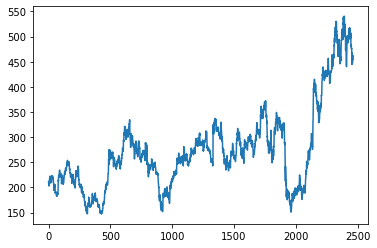

In [3]:
plt.plot(df.Close)

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [5]:
train_data = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
test_data = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

In [6]:
model = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10481.871, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10482.175, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10482.086, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10480.337, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10483.643, Time=1.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.834 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1724
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5239.169
Date:                Thu, 26 May 2022   AIC                          10480.337
Time:                        01:07:56   BIC                          10485.789
Sample:                             0   HQIC                         10482.354
                               - 1724                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        25.6259      0.246    104.134      0.000      25.144      26.108
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):             39144.30
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
import warnings
warnings.filterwarnings('ignore')

model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1723
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5237.306
Method:                       css-mle   S.D. of innovations              5.057
Date:                Thu, 26 May 2022   AIC                          10484.612
Time:                        01:07:57   BIC                          10511.871
Sample:                             1   HQIC                         10494.697
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0835      0.119      0.701      0.483      -0.150       0.317
ar.L1.D.Close     0.5347      0.563      0.950      0.342      -0.568       1.638
ma.L1.D.Close    -0.5030      0.562     -0.895      0.371      -1.605       0.599
ma.L2.D.Close    -0.0420      0.025     -1.670      0.095      -0.091       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8703           +0.0000j            1.8703            0.0000
MA.1            1.7362           +0.0000j            1.7362            0.0000
MA.2          -13.7118           +0.0000j           13.7118            0.5000
-----------------------------------------------------------------------------
"""

In [8]:
fc, se, conf = fitted.forecast(test_data.shape[0], alpha=0.05)

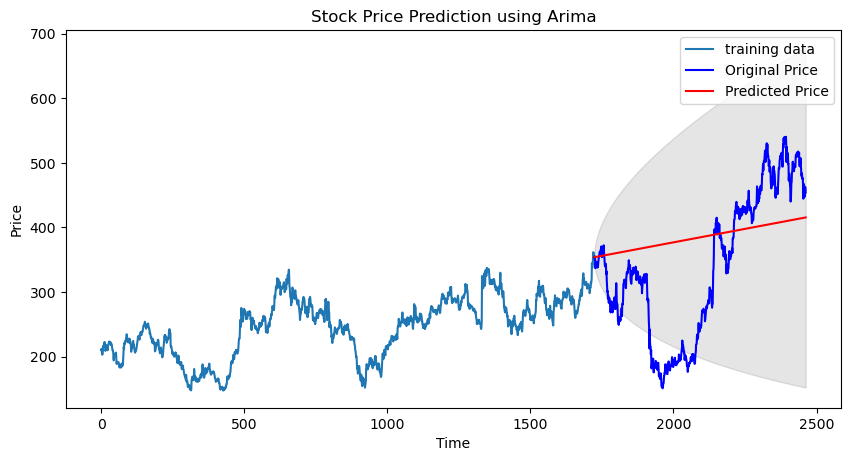

In [9]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, 'b', label = 'Original Price')
plt.plot(fc_series, 'r', label = 'Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction using Arima')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

test = np.array(test_data['Close'])

mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 11699.508085820582
MAE: 87.976531070585
RMSE: 108.16426436591978
MAPE: 0.3534634179728319
